In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,max_error, mean_squared_error, median_absolute_error, r2_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\Codes\Stocks\Data\NIFTY 50_minute.csv")
df.head()

,date,open,high,low,close,volume
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0


In [3]:
df_cl = df.drop(columns=['high','low','volume'])
df_cl.head()

,date,open,close
0,2015-01-09 09:15:00,8285.45,8292.10
1,2015-01-09 09:16:00,8292.60,8288.15
2,2015-01-09 09:17:00,8287.40,8293.90
3,2015-01-09 09:18:00,8294.25,8300.65
4,2015-01-09 09:19:00,8300.60,8301.20


In [43]:
df_cl.to_csv(r"C:\Users\Admin\Downloads\Codes\Stocks\Data\NIFTY 50_minute_raw.csv")

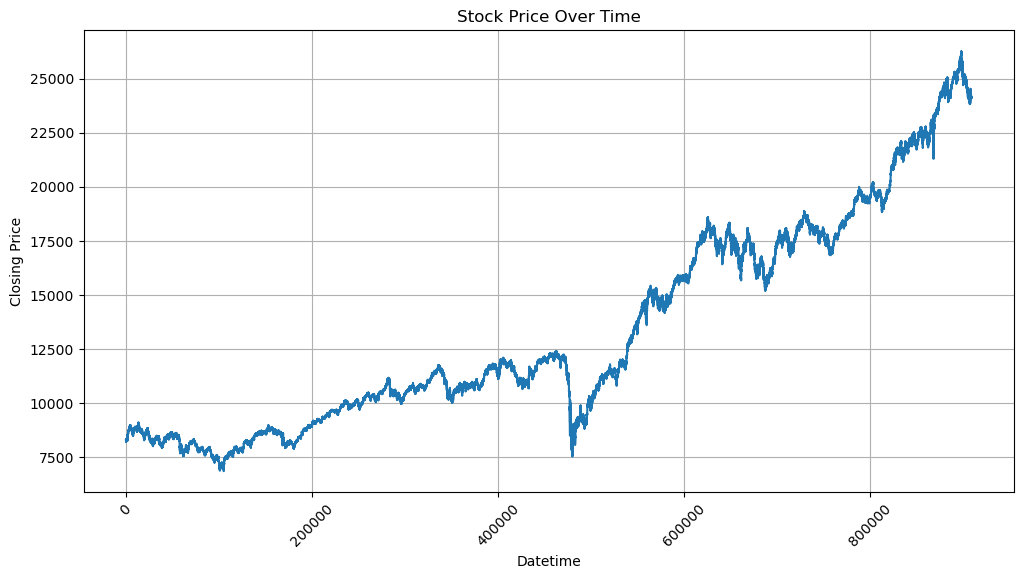

In [4]:
# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(df_cl.index, df_cl['close'])
plt.xlabel('Datetime')
plt.ylabel('Closing Price')
plt.title('Stock Price Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show() 

#### To Do:-
***
1) Make a column GAP which has gap opening for the day
2) Make another column with 15/30 mins close
3) Make 2 models to predict the close of the 15/30 min candle
4) We will just keep open, close of first 15/30 min candle, gap opening value and features extracted from date

In [5]:
df_cl['date'] = pd.to_datetime(df_cl['date'])
df_cl.set_index('date', inplace=True)

In [6]:
df_15min = df_cl.resample('15Min').agg({'close' : 'last', 'open' : 'first'})
df_30min = df_cl.resample('30Min').agg({'close' : 'last', 'open' : 'first'})
print(df_15min.shape,df_30min.shape)

(344761, 2) (172381, 2)


In [7]:
df_15min.tail()

,close,open
date,,
2024-11-08 14:15:00,24139.40,24136.60
2024-11-08 14:30:00,24169.45,24138.80
2024-11-08 14:45:00,24159.75,24169.55
2024-11-08 15:00:00,24156.05,24162.55
2024-11-08 15:15:00,24110.35,24156.05


In [8]:
def make_param(df):
    '''Takes dataframe with date as index and returns dataframe with gap_open at daily timeframe'''
    # Making daya close and day open to calculate gap opening
    df['day_close'] = df['close'].resample('D').last().reindex(df.index, method='ffill')
    df['day_open'] = df['open'].resample('D').first().reindex(df.index, method='ffill')

    # Finding gap openings for daily timeframe
    df['gap_open'] = df['day_open']-df['day_close'].shift(1)

    # Droppping Nulls due to holidays
    df.dropna(inplace=True)
    print(df.shape)
    # This will take close of first 15 min candle for close and open of day or open of first 15 min candle 
    df = df.resample('D').agg({'close':'first', 'open':'first', 'gap_open':'first'})
    df.dropna(inplace=True)
    return(df)

In [9]:
df_15 = make_param(df_15min)
df_15.head()

(60631, 5)


,close,open,gap_open
date,,,
2015-01-09,8285.55,8294.10,5.20
2015-01-12,8265.60,8291.35,-35.20
2015-01-13,8330.95,8346.15,42.35
2015-01-14,8300.70,8307.25,19.50
2015-01-15,8416.90,8425.20,-35.95


In [10]:
def extract_date(df):
    '''Extracts from date(index), hour of day, day of week, week of year, month of year and adds them and returns the data'''

    df['Date'] = df.index.date
    # df['hour_of_day'] = df.index.hour        # Extract the hour of the day
    df['day_of_week'] = df.index.dayofweek   # Extract the day of the week (0=Monday, 6=Sunday)
    df['week_of_year'] = df.index.isocalendar().week  # Extract the week of the year
    df['month_of_year'] = df.index.month     # Extract the month of the year
    df.drop('Date',axis=1,inplace=True)
    return(df)

In [11]:
df_15_pre = extract_date(df_15)
df_15_pre.head()

,close,open,gap_open,day_of_week,week_of_year,month_of_year
date,,,,,,
2015-01-09,8285.55,8294.10,5.20,4,2,1
2015-01-12,8265.60,8291.35,-35.20,0,3,1
2015-01-13,8330.95,8346.15,42.35,1,3,1
2015-01-14,8300.70,8307.25,19.50,2,3,1
2015-01-15,8416.90,8425.20,-35.95,3,3,1


In [12]:
df_15_pre.reset_index(inplace = True)
df_15_pre.drop(columns='date', inplace=True)
df_15_pre.head()

,close,open,gap_open,day_of_week,week_of_year,month_of_year
0,8285.55,8294.10,5.20,4,2,1
1,8265.60,8291.35,-35.20,0,3,1
2,8330.95,8346.15,42.35,1,3,1
3,8300.70,8307.25,19.50,2,3,1
4,8416.90,8425.20,-35.95,3,3,1


In [13]:
cat = ['day_of_week']
num = df_15_pre.columns.drop(['day_of_week','close'])

In [46]:
df_15_pre.shape

(2436, 6)

In [47]:
train = df_15_pre[:2001]
test = df_15_pre[2001:]

In [48]:
train.to_csv(r"C:\Users\Admin\Downloads\Codes\Stocks\Artifacts\train.csv")
test.to_csv(r"C:\Users\Admin\Downloads\Codes\Stocks\Artifacts\test.csv")

In [14]:
# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('Numerical Transorfmation', StandardScaler(), num),         #(name given, transformer used, list of features)
        ('Categorical Transformation', OneHotEncoder(), cat)          # Apply OneHotEncoder to categorical features
    ]
)

In [15]:
X_transformed = preprocessor.fit_transform(df_15_pre.drop(columns='close'))

In [16]:
# dump(preprocessor,'Transformer_01_Gap_Train.joblib')

In [17]:
X_transformed.shape

(2436, 11)

In [18]:
num_features = num  # Numerical columns remain the same
cat_features = preprocessor.named_transformers_['Categorical Transformation'].get_feature_names_out(cat)

# Combine numerical and categorical feature names
feature_names = list(num_features) + list(cat_features)

# Convert the transformed array to a DataFrame
transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

transformed_df.head()

,open,gap_open,week_of_year,month_of_year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,-1.049786,-0.038924,-1.636472,-1.599715,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.050354,-0.405601,-1.569407,-1.599715,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.039035,0.298255,-1.569407,-1.599715,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.047070,0.090865,-1.569407,-1.599715,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.022706,-0.412408,-1.569407,-1.599715,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
transformed_df['close'] = df_15_pre['close']

In [20]:
X_train, X_test,y_train, y_test = train_test_split(transformed_df.drop(columns='close'),transformed_df['close'],test_size=0.3,random_state=14)

#### Trainig RF

In [21]:
rf = RandomForestRegressor(200,oob_score=True,n_jobs=-1,verbose=2)
rf

RandomForestRegressor(n_estimators=200, n_jobs=-1, oob_score=True, verbose=2)

In [22]:
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.0s


building tree 1 of 200building tree 2 of 200
building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, oob_score=True, verbose=2)

In [23]:
rf.oob_score_

0.999895525578907

In [24]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [25]:
print('mean_absolute_error',mean_absolute_error(y_pred,y_test),'\nmean_absolute_percentage_error',mean_absolute_percentage_error(y_pred,y_test),
      '\nmax_error',max_error(y_pred,y_test),
      '\nmean_squared_error',mean_squared_error(y_pred,y_test),'\nmedian_absolute_error:- ',median_absolute_error(y_pred,y_test),
      '\nr2_score', r2_score(y_pred,y_test))

mean_absolute_error 32.308266757866626 
mean_absolute_percentage_error 0.0024878532664367086 
max_error 467.66200000001663 
mean_squared_error 2200.6967270614427 
median_absolute_error:-  24.107250000017302 
r2_score 0.9999059112566258


In [26]:
imp = rf.feature_importances_
imp

array([9.99910061e-01, 2.14339387e-05, 3.68920560e-05, 2.01072244e-05,
       3.10064182e-06, 2.05503504e-06, 1.78254850e-06, 1.85713561e-06,
       2.67575344e-06, 3.15507917e-08, 2.70674865e-09])

In [27]:
# Convert feature importances and names into a DataFrame for easier handling
feature_importances = pd.DataFrame({
    'Feature': feature_names,  # Replace with your feature names
    'Importance': imp
})

In [28]:
feature_importances

,Feature,Importance
0,open,9.999101e-01
1,gap_open,2.143394e-05
2,week_of_year,3.689206e-05
3,month_of_year,2.010722e-05
4,day_of_week_0,3.100642e-06
5,day_of_week_1,2.055035e-06
6,day_of_week_2,1.782548e-06
7,day_of_week_3,1.857136e-06
8,day_of_week_4,2.675753e-06
9,day_of_week_5,3.155079e-08


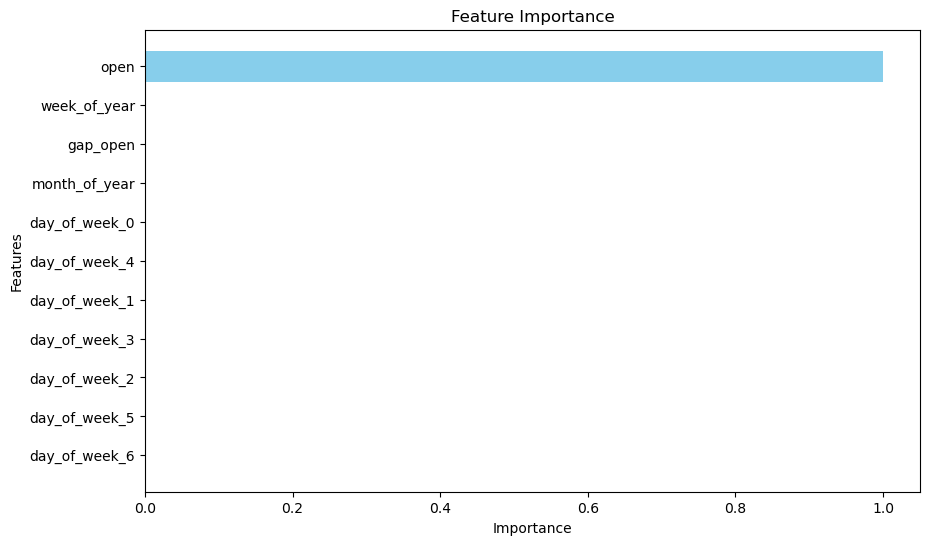

In [29]:
# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importances['Feature'], 
    feature_importances['Importance'], 
    color='skyblue'
)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()


In [30]:
# Create a DataFrame to compare true values and predictions
comparison_df = pd.DataFrame({
    'True Values': y_test,
    'Predictions': y_pred
})

In [31]:
# Join X_test with comparison_df based on index
comparison_with_features = pd.concat([X_test, comparison_df], axis=1)
comparison_with_features.head()

,open,gap_open,week_of_year,month_of_year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,True Values,Predictions
100,-1.105061,0.014171,-0.161054,-0.135703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8034.00,8036.12550
1200,-0.291060,0.378579,1.381429,1.328308,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11954.55,11967.91400
469,-1.078900,0.048207,1.515557,1.621110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8164.35,8157.82600
715,-0.628698,0.850994,1.448493,1.328308,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10307.60,10341.76725
1676,1.045903,1.340199,1.046106,1.035505,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18372.25,18435.78225


In [32]:
# Display the comparison DataFrame
print(comparison_df.sort_index().head(20))

    True Values  Predictions
3       8300.70   8301.34950
8       8741.55   8746.31275
9       8851.75   8806.15900
13      8949.10   8969.40100
16      8771.50   8800.11750
17      8730.65   8727.06875
18      8712.40   8683.75475
20      8546.60   8452.18875
24      8855.40   8805.03875
28      8853.30   8843.14100
31      8756.90   8790.21675
32      8737.95   8750.74425
33      8905.35   8907.87200
37      8943.85   8920.58250
39      8751.75   8766.09750
42      8815.75   8840.92900
45      8716.75   8749.21825
48      8591.45   8576.80475
50      8557.95   8573.11450
51      8481.75   8452.67600


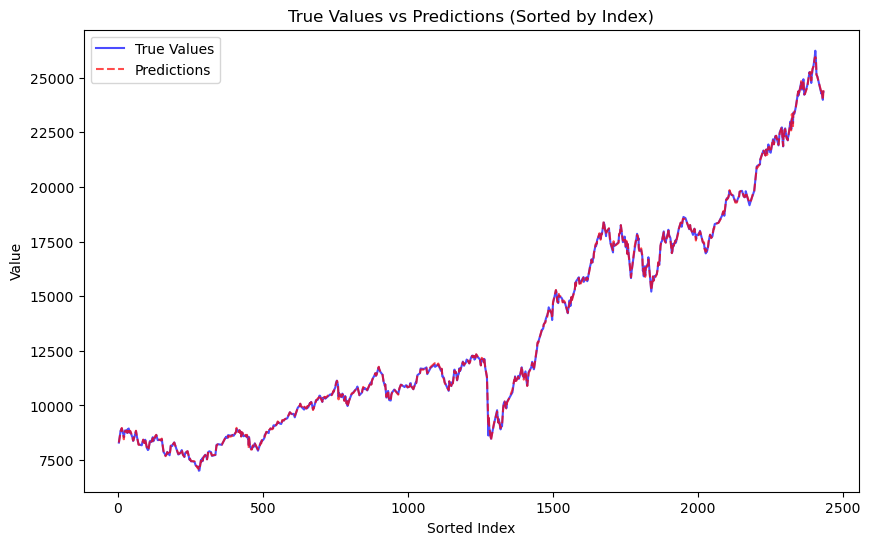

In [33]:
# Sort the index of y_test and y_pred
sorted_indices = y_test.sort_index().index

# Extract sorted true and predicted values
y_test_sorted = y_test.loc[sorted_indices]
y_pred_sorted = pd.Series(y_pred, index=y_test.index).loc[sorted_indices]

# Plot True Values and Predictions
plt.figure(figsize=(10, 6))
plt.plot(sorted_indices, y_test_sorted, label='True Values', color='blue', alpha=0.7)
plt.plot(sorted_indices, y_pred_sorted, label='Predictions', color='red', linestyle='--', alpha=0.7)
plt.xlabel('Sorted Index')
plt.ylabel('Value')
plt.title('True Values vs Predictions (Sorted by Index)')
plt.legend()
plt.show()

In [34]:
comparison_df['error'] = comparison_df['True Values'] - comparison_df['Predictions']
comparison_df.head()

,True Values,Predictions,error
100,8034.00,8036.12550,-2.12550
1200,11954.55,11967.91400,-13.36400
469,8164.35,8157.82600,6.52400
715,10307.60,10341.76725,-34.16725
1676,18372.25,18435.78225,-63.53225


In [35]:
comparison_df[abs(comparison_df['error'])>50]

,True Values,Predictions,error
1676,18372.25,18435.78225,-63.53225
24,8855.40,8805.03875,50.36125
1534,14833.85,14726.28400,107.56600
181,8048.10,7986.65200,61.44800
1553,14343.45,14286.62450,56.82550
...,...,...,...
1178,11699.10,11640.33575,58.76425
1320,8903.75,8967.02900,-63.27900
1697,17632.65,17723.28100,-90.63100
321,7866.50,7808.73475,57.76525


In [36]:
comparison_df.shape

(731, 3)

#### To Do:-
***
1) Take the model and transformer in output
2) Add all the inout signals to the comparison_df and take it in output for further analysis

In [37]:
from joblib import dump

In [38]:
# dump(rf,'RF_Gap_Prediction_01.joblib')

In [39]:
df_final = comparison_df.join(df_15_pre,how='left')
df_final.head()

,True Values,Predictions,error,close,open,gap_open,day_of_week,week_of_year,month_of_year
100,8034.00,8036.12550,-2.12550,8034.00,8026.50,11.05,1,24,6
1200,11954.55,11967.91400,-13.36400,11954.55,11967.30,51.20,4,47,11
469,8164.35,8157.82600,6.52400,8164.35,8153.15,14.80,1,49,12
715,10307.60,10341.76725,-34.16725,10307.60,10332.70,103.25,3,48,11
1676,18372.25,18435.78225,-63.53225,18372.25,18439.90,157.15,2,42,10


In [40]:
df_final.to_csv('Output_File_Gap_train.csv', index=False)

#### Case I - Model predicted upward move but market gave down

In [41]:
comparison_df

,True Values,Predictions,error
100,8034.00,8036.12550,-2.12550
1200,11954.55,11967.91400,-13.36400
469,8164.35,8157.82600,6.52400
715,10307.60,10341.76725,-34.16725
1676,18372.25,18435.78225,-63.53225
...,...,...,...
2098,19378.95,19413.86925,-34.91925
1114,11594.60,11622.90025,-28.30025
1152,11039.00,10992.83900,46.16100
553,9233.25,9207.55925,25.69075


#### Case II - Model predicted downward move but market gave upward

## Final purpose of the analysis: 
Make a real time model to predict the direction of price of nifty for next 5,15,30 minutes and the high and low of the price.
***

### Phase 1: Predict closing of next 15 minute candle
***
**Steps involved:-**
* Feature Engineeing
    * Make 5 and 15 minute data and remove 1 minute data
    * Start or end of day (initial and last 30 minutes)
    * Hour of day, Day of week, week of year, Month of year
    * Expiry Day
    * Simple and Exponential Moving average for 3,9,18,27,54    
* Approach
    * Scaling (Stnd Scaler) and encoding (one hot)
    * Approach 01 - Directly Predict/Forecast the closing price
    * Approach 02 - First use Classification to see direction and then prediction/forecasting 
***
**Output of Phase 1**: 
Make model to predict/forecast the closing of the next 15 minute candle with limited set of features.
***

### Make 5 and 15 minute datasets

Steps:
* make datetime column index
* mresample to get 5 minute data and agg the high and low to max and min, open and close to first and last
* extract date, hour of day, day of week, week of year, month of year 

In [42]:
def mov_avg(df, target):
    '''Adds Simple and Exponential Moving Averages for 3, 9, 18, 27, and 54 periods for the target column in the given data.'''
    
    periods = [3, 9, 18, 27, 54]
    base_name = '_'.join(target.split('_')[:2])
    
    for period in periods:
        # Simple Moving Average
        df[f'SMA_{period}_{base_name}'] = df[target].rolling(window=period).mean()
        
        # Exponential Moving Average
        df[f'EMA_{period}_{base_name}'] = df[target].ewm(span=period, adjust=False).mean()
    
    return df